## Install and import needed libaries

In [ ]:
!pip install infomap
!pip install python-louvain
!pip install cdlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.8/264.8 kB 647.1 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for infomap: filename=infomap-2.8.0-cp310-cp310-linux_x86_64.whl size=7695884 sha256=f07db006fcd000d939ce902a8faaab4eeb6b9c7000d5c276aa3dbad3d3609975
  Stored in directory: /root/.cache/pip/wheels/b5/0c/9b/9816a0207b931219a0c5b2edc14d84099ddd57f7097f926b16
Successfully built infomap
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.6/263.6 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 95.6 MB/s eta 0:00:00


In [ ]:
from sklearn.metrics import f1_score
import numpy as np
from infomap import Infomap
from math import sqrt
import networkx as nx
import random
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
from sklearn.metrics import f1_score
from cdlib import algorithms

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'bayanpy', 'leidenalg', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'leidenalg'}


## Cada implementation from GitHub

In [ ]:
class cada():
    def __init__(self, graph, algorithm='louvain', resolution=0.1):
        if algorithm == 'louvain':
            partition = community_louvain.best_partition(graph, resolution=resolution)
        elif algorithm == 'infomap':
            partition = self.run_infomap(graph)
        elif algorithm == 'label_propagation':
            partition = self.run_label_propagation(graph)
        elif algorithm == 'walktrap':
            partition = self.run_walktrap(graph)
        else:
            raise ValueError(f"Unknown algorithm: {algorithm}")

        communities = set()
        for node in graph.nodes():
            if node in partition:
                communities.add(partition[node])

        anom_score = {}

        # Compute anomaly score for each node
        for node in graph.nodes():
            comms = {}
            for neighbor in graph.neighbors(node):
                if neighbor != node:
                    if partition[neighbor] not in comms:
                        comms[partition[neighbor]] = 0

                    comms[partition[neighbor]] += 1

            if len(comms) > 0:
                # The number of communities it is connected to.
                comms = np.array(list(comms.values()))
                # print('nr communities connected', comms)
                max_com = np.max(comms)
                # print('Maxcommunity', max_com)
                comms = comms / max_com
                # print('Communities normalized', comms)
                anom_score[node] = np.sum(comms)
                # print('Anomaly score., ', anom_score[node])

        self.anomaly_scores = sorted(anom_score.items(), key=lambda x: x[1])[::-1]

    def run_infomap(self, graph):
        """
        Runs Infomap with infomap package
        """
        infomapSimple = Infomap("--two-level --silent")

        # Add edges to the Infomap object directly
        for e in graph.edges():
            infomapSimple.addLink(e[0], e[1])

        # Run Infomap
        infomapSimple.run()

        # Get the resulting partition
        partition = {}
        for node in infomapSimple.iterTree():
            if node.isLeaf():
                partition[node.physicalId] = node.moduleIndex()

        return partition

    def run_label_propagation(self, graph):
        """
        Runs Label Propagation using NetworkX
        """
        communities = nx.algorithms.community.label_propagation.asyn_lpa_communities(graph)
        partition = {}
        for i, community in enumerate(communities):
            for node in community:
                partition[node] = i
        return partition

    def run_walktrap(self, graph):
        """
        Runs Walktrap using the cdlib library.
        """
        walktrap_communities = algorithms.walktrap(graph)
        partition = {}
        for i, community in enumerate(walktrap_communities.communities):
            for node in community:
                partition[node] = i
        return partition

    # For calculating anomaly score
    def get_anomaly_scores(self, nr_anomalies=None):
        """
        Returns tuple (node, anomaly_score) for either nr_anomalies or all
        """
        if nr_anomalies:
            return self.anomaly_scores[:nr_anomalies]
        else:
            return self.anomaly_scores

    # Get the top anomalies (so with the highest anomaly scores)
    def get_top_anomalies(self, nr_anomalies=100):
        """
        Returns highest scoring anomalies
        """
        anomalies = []
        for anomaly in self.anomaly_scores[:nr_anomalies]:
            anomalies.append(anomaly[0])

        return anomalies

    # Get all anomalies with an anomaly score above a certain threshold
    def get_anomalies_threshold(self, threshold):
        """
        Returns anomalies that are above a certain threshold.
        """
        anomalies = []

        for anomaly in self.anomaly_scores:
            if anomaly[1] > threshold:
                anomalies.append(anomaly[0])
            else:
                break

        return anomalies

## Generate a synthetic network dataset

In [ ]:
def generate_lfr_benchmark(n, tau1, tau2, mu, k, k_max, seed):
    k = int(round(k))
    k_max = int(round(k_max))
    G = nx.LFR_benchmark_graph(n, tau1, tau2, mu, average_degree=k, max_degree=k_max,seed=seed)
    return G

## Adding random anomalies to the graph

In [ ]:
def inject_random_anomalies(G, k, k_max, tau1):
    num_anomalies = G.number_of_nodes() // 100
    new_nodes = []
    index = G.number_of_nodes()
    # Add num_anomalies new nodes
    for i in range(num_anomalies):
        new_node = index + i
        # Set the number of edges using a power-law distribution
        num_edges = np.clip(int(np.random.pareto(tau1 - 1) + k), int(k), int(k_max))
        # Randomly select neighbors from existing nodes
        neighbors = np.random.choice(list(G.nodes), num_edges, replace=False)
        # Add the new node to the graph
        G.add_node(new_node)
        # Connect the new node to the chosen neighbors
        for neighbor in neighbors:
            G.add_edge(new_node, neighbor)
        # Add the new node to the list of anomalies for reference
        new_nodes.append(new_node)
    return G, new_nodes


## Calculating the mean f1 score from a graph

In [ ]:
def mean_f1(graphs, anomalies, algorithm='louvain'):
    f1_list = []
    for index, graph in enumerate(graphs):
        # Initialize anomaly detector with specified algorithm
        anomaly_detector = cada(graph, algorithm=algorithm)
        predicted_anomalies = anomaly_detector.get_top_anomalies(100)
        # Create a list of all node IDs
        all_nodes = set(range(graph.number_of_nodes()))

        # Create true labels (1 for true anomalies, 0 for all other nodes)
        true_labels = []
        for node in all_nodes:
            # Use anomalies from inject_random_anomalies, not get_top_anomalies
            if node in anomalies[index]:
                true_labels.append(1)
            else:
                true_labels.append(0)

        # Create predicted labels (1 for predicted anomalies, 0 for all other nodes)
        predicted_labels = []
        for node in all_nodes:
            if node in predicted_anomalies:  # Use predicted_anomalies here
                predicted_labels.append(1)
            else:
                predicted_labels.append(0)

        # Calculate the F1 score
        f1 = f1_score(true_labels, predicted_labels)
        f1_list.append(f1)
    return np.mean(f1_list)

## Experiment with different node sizes

### Define the non-changing parameters

In [ ]:
mu = 0.2
tau1 = 3
tau2 = 2
t1 = 4

### Calculate f1 score with a given node size

In [ ]:
def f1_score_node_size(n, algorithm='louvain'):
    graphs = []
    all_anomalies = []
    # Create 5 different graphs with the same parameter but different seed
    k = (2*n**1.15) / n
    k_max = n**(1/(t1-1))
    for i in range(5):
        G = generate_lfr_benchmark(n, tau1, tau2, mu, k, k_max, i)
        G, anomalies = inject_random_anomalies(G, k, k_max, tau1)
        graphs.append(G)
        all_anomalies.append(anomalies)
    f1 = mean_f1(graphs, all_anomalies, algorithm=algorithm)
    return f1

In [ ]:
node_sizes = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000,12000,13000,14000,15000]

# Generate scores for Louvain
scores_louvain = [f1_score_node_size(n, algorithm='louvain') for n in node_sizes]
# Save in numpy in case your pc can't handle all algorithms at once
np.save('/home/scores_louvain_n.npy', scores_louvain)

In [ ]:
# Generate scores for Infomap
scores_infomap = [f1_score_node_size(n, algorithm='infomap') for n in node_sizes]
# Save in numpy in case your pc can't handle all algorithms at once
np.save('/home/scores_infomap_n.npy', scores_infomap)

In [ ]:
# Generate scores for Label Propagation
scores_label_propagation = [f1_score_node_size(n, algorithm='label_propagation') for n in node_sizes]
# Save in numpy in case your pc can't handle all algorithms at once
np.save('/home/scores_label_n.npy', scores_label_propagation)

In [ ]:
# Generate scores for Walktrap
scores_walktrap = [f1_score_node_size(n, algorithm='walktrap') for n in node_sizes]
# Save in numpy in case your pc can't handle all algorithms at once
np.save('/home/scores_walktrap_n.npy', scores_walktrap)

### Load the data and plot the f1 scores for the different node sizes

In [ ]:
scores_louvain = np.load('/home/scores_louvain.npy').tolist()
scores_label_propagation = np.load('/home/scores_label.npy').tolist()
scores_infomap = np.load('/home/scores_infomap.npy').tolist()
scores_walktrap = np.load('/home/scores_walktrap.npy').tolist()

# Create tick labels by dividing node_sizes by 1000
tick_labels = [size // 1000 for size in node_sizes]

# Plot the results
plt.plot(node_sizes, scores_louvain, '-o', label='Louvain')
plt.plot(node_sizes, scores_infomap, '-o', label='Infomap')
plt.plot(node_sizes, scores_label_propagation, '-o', label='Label Propagation')
plt.plot(node_sizes, scores_walktrap, '-o', label='Walktrap')

# Set ticks and labels
plt.xticks(node_sizes, tick_labels)
plt.xlabel('Node Size (X 1000)')
plt.ylabel('F1 Score')
plt.legend()
plt.show()


## Experiment with different mu

### Define the non-changing parameters

In [ ]:
n = 10000
tau1 = 3
tau2 = 2
k = 2 * n**0.15
t1 = 4
k_max = n**(1/(t1-1))

### Calculate f1 score with a given mu

In [ ]:
def f1_score_mu(mu, algorithm='louvain'):
    graphs = []
    all_anomalies = []
    # Create 5 different graphs with the same parameter but different seed
    for i in range(5):
        G = generate_lfr_benchmark(n, tau1, tau2, mu, k, k_max, i)
        G, anomalies = inject_random_anomalies(G, k, k_max, tau1)
        graphs.append(G)
        all_anomalies.append(anomalies)
    f1 = mean_f1(graphs, all_anomalies, algorithm=algorithm)
    return f1

In [ ]:
mus = [0.2, 0.3, 0.4, 0.5, 0.6]

# Generate scores for Louvain
scores_louvain = [f1_score_mu(mu, algorithm='louvain') for mu in mus]
np.save('/home/scores_louvain_mus.npy', scores_louvain)

# Generate scores for Infomap
scores_infomap = [f1_score_mu(mu, algorithm='infomap') for mu in mus]
np.save('/home/scores_infomap_mus.npy', scores_infomap)

# Generate scores for Label Propagation
scores_label_propagation = [f1_score_mu(mu, algorithm='label_propagation') for mu in mus]
np.save('/home/scores_labelpropagation_mus.npy', scores_label_propagation)

# Generate scores for Walktrap
scores_walktrap = [f1_score_mu(mu, algorithm='walktrap') for mu in mus]
np.save('/home/scores_walktrap_mus.npy', scores_walktrap)

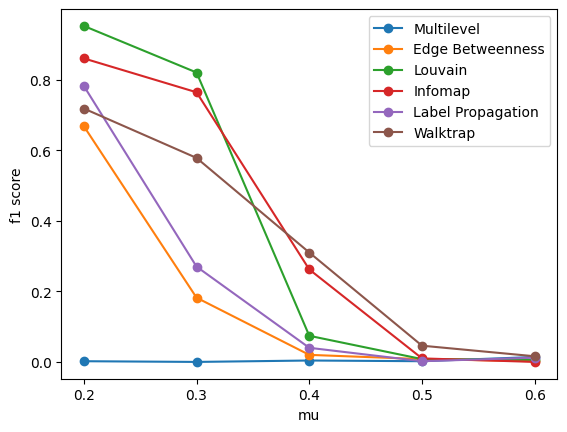

In [ ]:
mus = [0.2, 0.3, 0.4, 0.5, 0.6]

plt.plot(mus, scores_louvain, '-o', label='Louvain')
plt.plot(mus, scores_infomap, '-o', label='Infomap')
plt.plot(mus, scores_label_propagation, '-o', label='Label Propagation')
plt.plot(mus, scores_walktrap, '-o', label='Walktrap')
plt.xticks(mus)
plt.xlabel('mu')
plt.ylabel('f1 score')
plt.legend()
plt.show()

### Plot the f1 scores for different mu

In [ ]:
# Plot the results
plt.plot(mus, scores_louvain, '-o', label='Louvain')
plt.plot(mus, scores_infomap, '-o', label='Infomap')
plt.plot(mus, scores_label_propagation, '-o', label='Label Propagation')
plt.plot(mus, scores_walktrap, '-o', label='Walktrap')
plt.xticks(mus)
plt.xlabel('mu')
plt.ylabel('f1 score')
plt.legend()
plt.show()

## Experiment with different t1

### Define the non-changing parameters

In [ ]:
n = 10000
tau1 = 3
tau2 = 2
k = (2*n**1.15) / n
mu = 0.6

### Calculate f1 score with a given t1

In [ ]:
def f1_score_t1(t1, algorithm='louvain'):
    graphs = []
    all_anomalies = []
    k_max = n**(1/(t1-1))
    # Create 5 different graphs with the same parameter but different seed
    for i in range(5):
        G = generate_lfr_benchmark(n, tau1, tau2, mu, k, k_max, i)
        G, anomalies = inject_random_anomalies(G, k, k_max, tau1)
        graphs.append(G)
        all_anomalies.append(anomalies)
    f1 = mean_f1(graphs, all_anomalies, algorithm=algorithm)
    return f1

In [ ]:
t1s = [2, 3, 4, 5, 6]

# Generate scores for Louvain
scores_louvain = [f1_score_t1(t1, algorithm='louvain') for t1 in t1s]

# Generate scores for Infomap
scores_infomap = [f1_score_t1(t1, algorithm='infomap') for t1 in t1s]

# Generate scores for Label Propagation
scores_label_propagation = [f1_score_t1(t1, algorithm='label_propagation') for t1 in t1s]

# Generate scores for Walktrap
scores_walktrap = [f1_score_t1(t1, algorithm='walktrap') for t1 in t1s]

### Plot the f1 scores for different t1


In [ ]:
# Plot the results
plt.plot(t1s, scores_louvain, '-o', label='Louvain')
plt.plot(t1s, scores_infomap, '-o', label='Infomap')
plt.plot(t1s, scores_label_propagation, '-o', label='Label Propagation')
plt.plot(t1s, scores_walktrap, '-o', label='Walktrap')
plt.xlabel('t1')
plt.ylabel('f1 score')
plt.legend()
plt.show()

## Experiment with different tau1

### Define the non-changing parameters

In [ ]:
n = 10000
tau2 = 2
k = (2*n**1.15) / n
mu = 0.2
t1 = 4
k_max = n**(1/(t1-1))

### Calculate f1 score with a given tau1

In [ ]:
def f1_score_tau1(tau1, algorithm='louvain'):
    graphs = []
    all_anomalies = []
    # Create 5 different graphs with the same parameter but different seed
    for i in range(5):
        G = generate_lfr_benchmark(n, tau1, tau2, mu, k, k_max, i)
        G, anomalies = inject_random_anomalies(G, k, k_max, tau1)
        graphs.append(G)
        all_anomalies.append(anomalies)
    f1 = mean_f1(graphs, all_anomalies, algorithm=algorithm)
    return f1

In [ ]:
tau1s = [2.0, 2.5, 3, 3.5, 4.0]

scores_louvain = [f1_score_tau1(tau1, algorithm='louvain') for tau1 in tau1s]
scores_infomap = [f1_score_tau1(tau1, algorithm='infomap') for tau1 in tau1s]
scores_label_propagation = [f1_score_tau1(tau1, algorithm='label_propagation') for tau1 in tau1s]
scores_walktrap = [f1_score_tau1(tau1, algorithm='walktrap') for tau1 in tau1s]

In [ ]:
np.save('/home/scores_louvain_tau1.npy', scores_louvain)
np.save('/home/scores_infomap_tau1.npy', scores_infomap)
np.save('/home/scores_labelpropagation_tau1.npy', scores_label_propagation)
np.save('/home/scores_walktrap_tau1.npy', scores_walktrap)

### Plot the f1 scores for different tau1

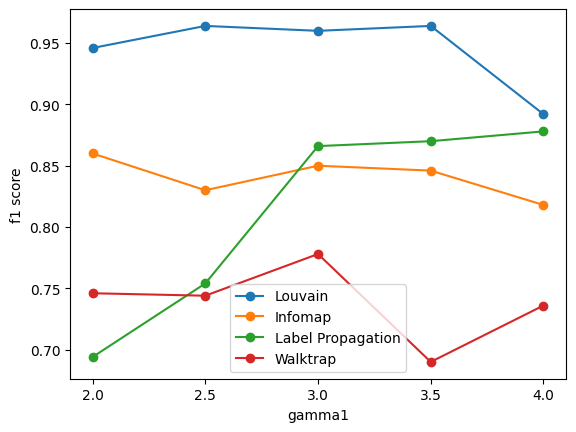

In [ ]:
# Plot the results
plt.plot(tau1s, scores_louvain, '-o', label='Louvain')
plt.plot(tau1s, scores_infomap, '-o', label='Infomap')
plt.plot(tau1s, scores_label_propagation, '-o', label='Label Propagation')
plt.plot(tau1s, scores_walktrap, '-o', label='Walktrap')
plt.xlabel('tau1')
plt.xticks(tau1s)
plt.ylabel('f1 score')
plt.legend()
plt.show()

## Experiment with different tau2

### Define the non-changing parameters

In [ ]:
n = 10000
tau1 = 3
k = (2*n**1.15) / n
mu = 0.2
t1 = 4
k_max = n**(1/(t1-1))

### Calculate f1 score with a given tau2

In [ ]:
def f1_score_tau2(tau2, algorithm='louvain'):
    graphs = []
    all_anomalies = []
    # Create 5 different graphs with the same parameter but different seed
    for i in range(5):
        G = generate_lfr_benchmark(n, tau1, tau2, mu, k, k_max, i)
        G, anomalies = inject_random_anomalies(G, k, k_max, tau1)
        graphs.append(G)
        all_anomalies.append(anomalies)
    f1 = mean_f1(graphs, all_anomalies, algorithm=algorithm)
    return f1

In [ ]:
tau2s = [1.5, 2, 2.5, 3]

scores_louvain = [f1_score_tau2(tau2, algorithm='louvain') for tau2 in tau2s]
scores_infomap = [f1_score_tau2(tau2, algorithm='infomap') for tau2 in tau2s]
scores_label_propagation = [f1_score_tau2(tau2, algorithm='label_propagation') for tau2 in tau2s]
scores_walktrap = [f1_score_tau2(tau2, algorithm='walktrap') for tau2 in tau2s]

In [ ]:
np.save('/home/scores_louvain_tau2.npy', scores_louvain)
np.save('/home/scores_infomap_tau2.npy', scores_infomap)
np.save('/home/scores_labelpropagation_tau2.npy', scores_label_propagation)
np.save('/home/scores_walktrap_tau2.npy', scores_walktrap)

### Plot the f1 scores for different tau2

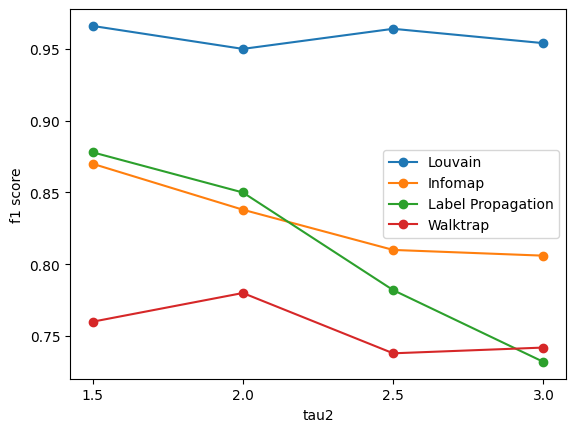

In [ ]:
# Plot the results
plt.plot(tau2s, scores_louvain, '-o', label='Louvain')
plt.plot(tau2s, scores_infomap, '-o', label='Infomap')
plt.plot(tau2s, scores_label_propagation, '-o', label='Label Propagation')
plt.plot(tau2s, scores_walktrap, '-o', label='Walktrap')
plt.xlabel('tau2')
plt.xticks(tau2s)
plt.ylabel('f1 score')
plt.legend()
plt.show()